Install `xlrd` for reading the `xls` file

In [2]:
# %conda install xlrd==2.0.1

Set the path to the `xls` file

In [1]:
training_file = "TrainDataset2024.xls"
# training_file = "/kaggle/input/dataset/TrainDataset2024.xls"

Import libraries

In [511]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.svm import SVC



from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

from imblearn.over_sampling import SMOTE

from pickle import dump , load

import warnings

### Cleaning the data

In [515]:
data = pd.read_excel(training_file)
data.drop(["ID", "RelapseFreeSurvival (outcome)"], axis=1, inplace=True)
data_no_na = data.replace(999, np.nan)
data_no_na.dropna(ignore_index=True, inplace=True)
X = data_no_na.drop('pCR (outcome)', axis=1)
y = data_no_na['pCR (outcome)']

print("Read the data into X and y. Dropped all rows with missing value.")

Read the data into X and y. Dropped all rows with missing value.


<Figure size 640x480 with 0 Axes>

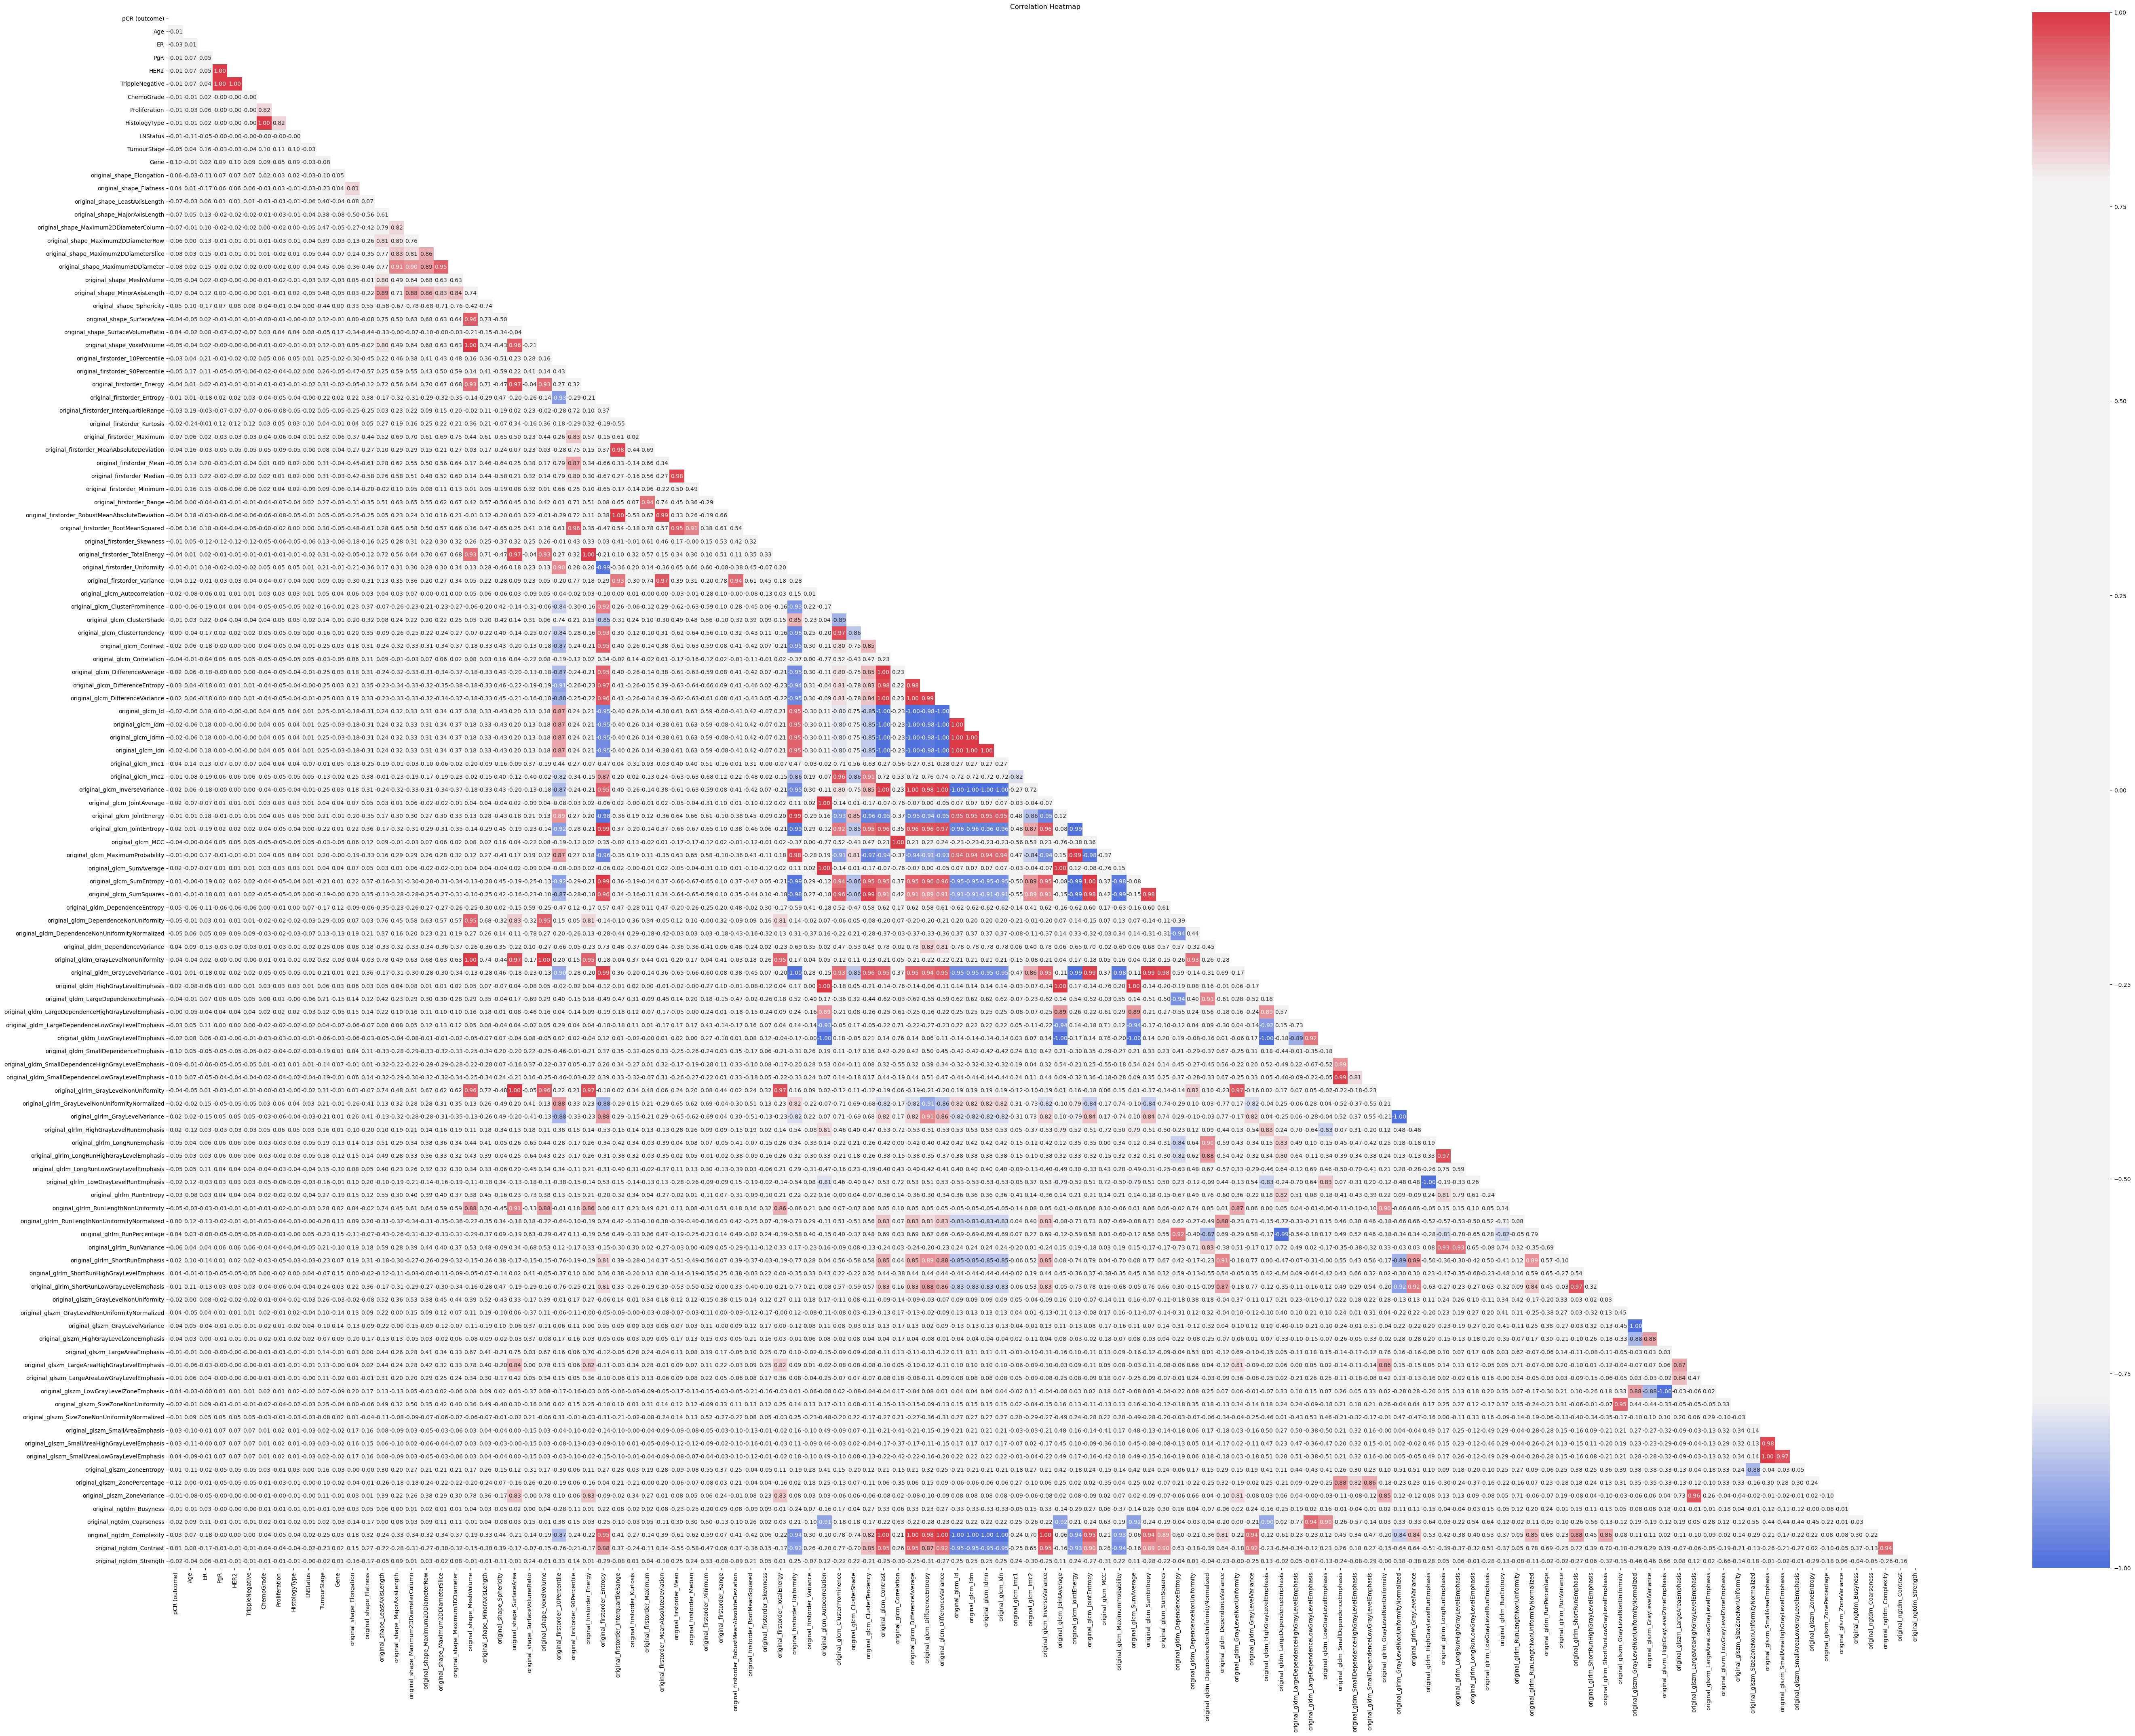

In [537]:
# Create a correlation matrix
correlation_matrix = data.corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Create a heatmap with a custom colormap and normalization
plt.clf()
plt.figure(figsize=(70, 50))
cmap = sns.diverging_palette(260, 10, sep=200, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=cmap, mask=mask, square=False)
plt.title('Correlation Heatmap')
plt.show()

Split the data into train_full and test (untouched)

In [489]:
# X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=11) # similar distribution of 1 and 0
X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=None)

X_train_full.reset_index(drop=True, inplace=True)
X_test_reserved.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)
y_test_reserved.reset_index(drop=True, inplace=True)

ratio_train = sum(y_train_full[y_train_full==1]) / len(y_train_full)
ratio_test = sum(y_test_reserved[y_test_reserved==1]) / len(y_test_reserved)

print("Splited the data into train and test. The test will not be used in the training, but just for test the model. ")
print(f"The training data has {len(X_train_full)} data. The testing data has {len(X_test_reserved)} data. ")
print(f"Positive ratio: \n\tTrain: {ratio_train:.5f}\n\tTest: {ratio_test:.5f}")


Splited the data into train and test. The test will not be used in the training, but just for test the model. 
The training data has 246 data. The testing data has 62 data. 
Positive ratio: 
	Train: 0.16667
	Test: 0.19355


### Normalisation

#### Standardisation

In [490]:
scaler = StandardScaler()
Xs_standardisation = scaler.fit_transform(X_train_full)
Xs_standardisation = pd.DataFrame(Xs_standardisation, columns=X_train_full.columns)

with open("pkl/StandardScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/StandardScaler.pkl'")

Saved scaler to 'pkl/StandardScaler.pkl'


### Robust Scaler

In [491]:
scaler = RobustScaler()
Xs_robustScaler = scaler.fit_transform(X_train_full)
Xs_robustScaler = pd.DataFrame(Xs_robustScaler, columns=X_train_full.columns)

with open("pkl/RobustScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/RobustScaler.pkl'")

Saved scaler to 'pkl/RobustScaler.pkl'


### Feature Selection

In [492]:
SCALER = "standard"

In [493]:
# SCALER = "robust"

In [494]:
if SCALER == "standard":
    Xs = Xs_standardisation
else:
    Xs = Xs_robustScaler

In [495]:
# # Replaced by the following parallel process code generated by AI

# TARGET_NUM_OF_FEATURES = 10

# features = {}
# for K in range(1, TARGET_NUM_OF_FEATURES + 5):
#     best = {}
#     for i in range(K+5):
#         k_best = SelectKBest(score_func=mutual_info_classif, k=K)
#         Xs_k_best = k_best.fit_transform(Xs, y_train_full)
#         for feature in (k_best.get_feature_names_out()):
#             if feature in best:
#                 best[feature] += 1
#             else:
#                 best[feature] = 1
#     sorted_best = dict(sorted(best.items(), key=lambda item: item[1], reverse=True))
#     for key in best:
#         if best[key] > (K-2):
#             if key in features:
#                 features[key] += 1
#             else:
#                 features[key] = 1

# sorted_best

In [496]:
TARGET_NUM_OF_FEATURES = 10

from joblib import Parallel, delayed

features = {}

def process_k_best(K, i):
    k_best = SelectKBest(score_func=mutual_info_classif, k=K)
    Xs_k_best = k_best.fit_transform(Xs, y_train_full)
    return k_best.get_feature_names_out()

# Run in parallel
for K in range(1, TARGET_NUM_OF_FEATURES + 5):
    best = {}
    results = Parallel(n_jobs=-1)(delayed(process_k_best)(K, i) for i in range(K + 5))
    
    for feature_list in results:
        for feature in feature_list:
            if feature in best:
                best[feature] += 1
            else:
                best[feature] = 1

    sorted_best = dict(sorted(best.items(), key=lambda item: item[1], reverse=True))
    
    # Update features based on the counts
    for key in best:
        if best[key] > (K - 2):
            features[key] = features.get(key, 0) + 1

# Final sorted best features
sorted_best

{'Gene': 19,
 'original_firstorder_90Percentile': 19,
 'original_firstorder_RobustMeanAbsoluteDeviation': 19,
 'original_gldm_DependenceNonUniformityNormalized': 19,
 'original_gldm_GrayLevelNonUniformity': 19,
 'original_glrlm_ShortRunEmphasis': 19,
 'original_glrlm_ShortRunLowGrayLevelEmphasis': 19,
 'original_glszm_ZonePercentage': 19,
 'original_firstorder_Energy': 18,
 'original_firstorder_TotalEnergy': 18,
 'HER2': 13,
 'PgR': 9,
 'original_shape_Maximum3DDiameter': 9,
 'original_ngtdm_Strength': 7,
 'original_glrlm_HighGrayLevelRunEmphasis': 6,
 'original_glrlm_LowGrayLevelRunEmphasis': 6,
 'original_gldm_DependenceNonUniformity': 5,
 'ER': 5,
 'LNStatus': 5,
 'TrippleNegative': 3,
 'ChemoGrade': 2,
 'HistologyType': 2,
 'Proliferation': 2,
 'TumourStage': 2,
 'original_ngtdm_Coarseness': 1,
 'original_glrlm_GrayLevelVariance': 1}

In [497]:
sorted_features = dict(sorted(features.items(), key=lambda item: item[1], reverse=True))
feature_names = list(sorted_features.keys())

num_max = sum(np.array(list(sorted_best.values())) == max(sorted_best.values()))

num_of_features = max(num_max, TARGET_NUM_OF_FEATURES)

important_features = ["Gene", "ER", "HER2"]

selected_features = list(set(important_features + feature_names[:num_of_features]))
num_of_features = len(selected_features)

print(f"Best {num_of_features} features are: ")
print(selected_features)

with open("pkl/selected_features.pkl", "wb") as file:
    dump(selected_features, file)

Best 11 features are: 
['original_gldm_GrayLevelNonUniformity', 'PgR', 'original_glszm_ZonePercentage', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_gldm_DependenceNonUniformityNormalized', 'original_firstorder_90Percentile', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'ER', 'Gene', 'original_glrlm_ShortRunEmphasis', 'HER2']


In [498]:
# selected_features = feature_names[:6]
# with open("pkl/selected_features.pkl", "wb") as file:
#     dump(selected_features, file)

### PCA

In [499]:
NUM_OF_PCA_FEATURE = 7

Xs_selected = Xs[selected_features]

pca = PCA(n_components=10)
X_pca = pca.fit_transform(Xs_selected)

with open("pkl/pca.pkl", mode="wb") as file:
  dump(pca, file)

X_pca = X_pca[:, :NUM_OF_PCA_FEATURE]

#### Resample

In [500]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_train_full)

print(X_resampled.shape)
print(y_resampled.shape)

(410, 7)
(410,)


#### SVM

In [501]:
model = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.1],
    'gamma': ['scale', 'auto'] + [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'degree': [1, 2]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1, return_train_score=True)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

pd.DataFrame(grid_search.cv_results_).to_csv('output.csv')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 0.1, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8121951219512196


<Figure size 640x480 with 0 Axes>

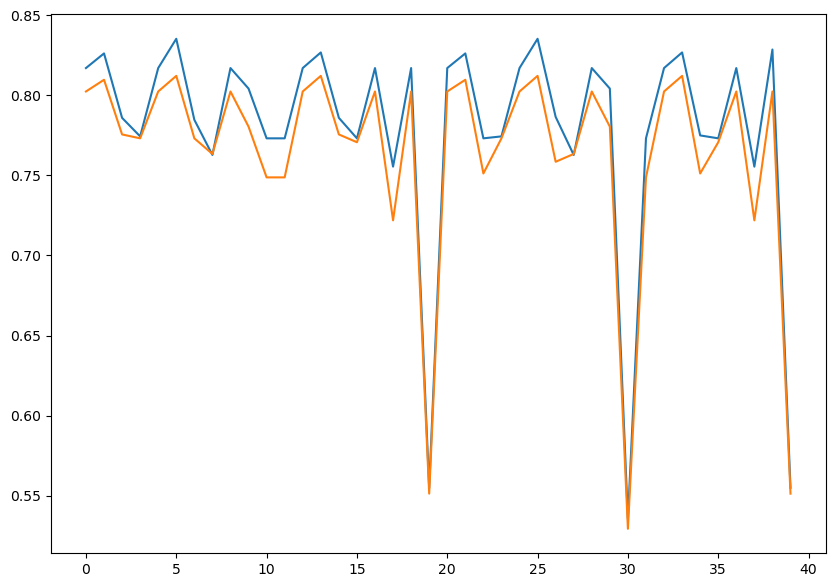

In [502]:
plt.clf()
plt.figure(figsize=(10, 7))
results = grid_search.cv_results_
plt.plot(results["mean_train_score"])
plt.plot(results["mean_test_score"])

In [503]:
# result_df = pd.DataFrame(results)
# filtered = result_df[(result_df["mean_train_score"]-result_df["mean_test_score"] > 0.1)]
# filtered.to_csv('output.csv')
# plt.clf()
# plt.figure(figsize=(10, 7))
# plt.plot(filtered["mean_train_score"])
# plt.plot(filtered["mean_test_score"])

In [504]:
# result_df = pd.DataFrame(results)
# filtered = result_df[(result_df["mean_train_score"]< 0.6)]
# filtered.to_csv('filtered.csv')

### Check the accuracy with `test_reserved`

In [505]:
with open("pkl/StandardScaler.pkl", "rb") as file:
  scaler = load(file)

with open("pkl/selected_features.pkl", "rb") as file:
  selected_features = load(file)

with open("pkl/pca.pkl", "rb") as file:
  pca = load(file)

model = grid_search.best_estimator_

X_test = scaler.transform(X_test_reserved)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_test = X_test[selected_features]

X_test = pca.transform(X_test)[:, :NUM_OF_PCA_FEATURE]

print(f"Shape of X_test: {X_test.shape}")

y_pred = model.predict(X_resampled)
report = classification_report(y_resampled, y_pred)
cm = confusion_matrix(y_resampled, y_pred)

print(f"TARGET_NUM_OF_FEATURES: {TARGET_NUM_OF_FEATURES}, scaler: {SCALER}, num_of_features: {num_of_features}")

print("\nBest Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

print("\nTraining set:")
print(report)
print(cm)

y_pred = model.predict(X_test)
report = classification_report(y_test_reserved, y_pred)
cm = confusion_matrix(y_test_reserved, y_pred)

print("Untouched testing set:")
print(report)
print(cm)



Shape of X_test: (62, 7)
TARGET_NUM_OF_FEATURES: 10, scaler: standard, num_of_features: 11

Best Parameters: {'C': 0.1, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8121951219512196

Training set:
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       205
         1.0       0.81      0.84      0.83       205

    accuracy                           0.82       410
   macro avg       0.82      0.82      0.82       410
weighted avg       0.82      0.82      0.82       410

[[165  40]
 [ 32 173]]
Untouched testing set:
              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83        50
         1.0       0.44      0.92      0.59        12

    accuracy                           0.76        62
   macro avg       0.71      0.82      0.71        62
weighted avg       0.87      0.76      0.78        62

[[36 14]
 [ 1 11]]
